# STEP51 MNISTの学習

## このステップの概要

### 前のステップ, STEP49, STEP50で学んだこと

STEP49とSTEP50でデータセットを容易にあつかえる仕組みを作ってきた.

- STEP49: Datasetクラスによるデータセットの取り扱いが共通化された
    - 巨大なデータをあつかう仕組み
    - 前処理
- STEP50: DaloaderクラスによってDatasetからミニバッチを作れるようになった

### STEP51の目的

データセットを扱える仕組みを新しいデータセットであるMNISTに対して実際に適用してみる。
MNISTを取り扱う中で、活性化関数であるReLuを取り入れ作成できるモデルを改良する。

- 51.1 MNISTデータセット
    - `datasets.py` に MNISTクラスを用意する
- 51.2 MNISTの学習
    - MNISTの学習を行ってみる
- 51.3 モデルの改良
    - 活性化関数 `ReLu` の適用



これまで何をやったか、まとめています。目次より、少し詳しい情報となっています。

https://qiita.com/daikumatan/private/1c4ba888ed1928c55fb2

#### 少しだけコードを振り返る

In [1]:
from dezero.datasets import Spiral
from dezero.dataloaders import DataLoader

batch_size = 10
max_eporch = 1

# train=True|False はテストデータ作成時の乱数のseed値が変わるだけ
train_set = Spiral(train=True)
test_set = Spiral(train=False)

# `__len__`をオーバーライドしているからサイズを求めることができる
# typeは dezero.datasets.Spiral とクラス名になる
print("train data size:", len(train_set), type(train_set))
print(" test data size", len(test_set), type(test_set))

# 一方`__getitem__`をオーバーライドしているので、下記のような使い方ができる
#　このとき、各配列には、trainデータと、ラベル情報がタプルでセットになった状態で保存される
for i, (x, t) in enumerate(train_set):
    #print(i, val)
    # これで、データとラベルを分離できる
    print(i, x, t)

train data size: 300 <class 'dezero.datasets.Spiral'>
 test data size 300 <class 'dezero.datasets.Spiral'>
0 [-0.13981389 -0.00721657] 1
1 [0.37049392 0.5820947 ] 1
2 [ 0.1374263  -0.17179643] 2
3 [0.3031688 0.06472  ] 0
4 [-0.20848857  0.53050214] 1
5 [-0.7074377 -0.13391  ] 2
6 [ 0.49455667 -0.3739167 ] 0
7 [0.23201972 0.13808277] 0
8 [-0.15886047 -0.01906173] 1
9 [ 0.00491708 -0.33996445] 2
10 [-0.12995958 -0.00324155] 1
11 [-0.23974584  0.25499398] 1
12 [-0.33211905 -0.42578977] 2
13 [-0.14406797  0.65432745] 1
14 [-0.08773611  0.4820813 ] 1
15 [-0.84679544  0.35963517] 2
16 [0.34992874 0.6062589 ] 1
17 [-0.2656141  -0.39981142] 2
18 [ 0.03873516 -0.28740144] 2
19 [-0.17989218  0.00622921] 1
20 [-0.26522237 -0.45886502] 2
21 [-0.01586872  0.5397668 ] 1
22 [0.15063146 0.1868426 ] 0
23 [-0.7781106   0.05425706] 2
24 [-0.10568184 -0.03051801] 1
25 [0.17171463 0.18169777] 0
26 [-0.05060399 -0.427012  ] 2
27 [-0.5878122  -0.22666465] 2
28 [ 0.42734203 -0.10477977] 0
29 [0.01999407 0.000

In [2]:
# これで、バッチ用データ生成の準備完了
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

Spiralクラスは`Dataset()`クラスを継承。具体的な処理は`prepare()` メソッドをオーバーロードする

```python
class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)
```

親クラスである`Dataset()`クラスのコンストラクター引数と返り値に注目してみる

```python
class Dataset:
    def __init__(self, train=True, transform=None, target_transform=None):
        """
        Args:
            train (boolean): True | False
            transform (function): Fucntion Object for data
            target_transform (function):  Fucntion Object for data
        """
          :
        (省略)
          :
    def __getitem__(self, index):
          :
        (省略)
          :
        if self.label is None:
            return self.transform(self.data[index]), None
        else:
            return self.transform(self.data[index]),\
                   self.target_transform(self.label[index])
```

DatasetLoaderのコンストラクターでデータセットを受け取る

```python
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True, gpu=False):
            """
            引数をインスタンス変数に格納する。
            その後resetメソッドを呼び出し、イタレーションの回数を0に設定する。必要に応じてShuffleする。
            """
          :
        (省略)
          :
def __next__(self):
          :
        (省略)
          :
        x = np.array([example[0] for example in batch])
        t = np.array([example[1] for example in batch])
        self.iteration += 1
        return x, t
```




## 事前準備

In [3]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
from dezero import Variable
from dezero import as_variable, as_array
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

## 51.1 MNISTデータセット

### MNISTクラスの実装

- MNISTとは、手書き数字の画像のパブリックデータセットであり、Deep LearningのHello Worldとしてよく使われるデータである
- `datasets.py` にMNISTクラスを作成し、データのダウンロードおよび前処理するクラスを実現する

```python
class MNIST(Dataset):

    def __init__(self, train=True,
                 transform=Compose([Flatten(),             # [前処理] 28*28のフラットなベクトルに変換
                                    ToFloat(),             # [前処理] Floatに変換
                                    Normalize(0., 255.)]), # [前処理] 標準化の実施
                 target_transform=None):                   # ラベルに対する前処理はなし
        # 上記で前処理関数を設定したので、親クラスの初期化メソッドを行っている
        super().__init__(train, transform, target_transform)

    def prepare(self):
        '''
        Datasetクラスの`prepare()`メソッドをオーバーライド
        '''
        url = 'http://yann.lecun.com/exdb/mnist/'
        train_files = {'target': 'train-images-idx3-ubyte.gz',
                       'label': 'train-labels-idx1-ubyte.gz'}
        test_files = {'target': 't10k-images-idx3-ubyte.gz',
                      'label': 't10k-labels-idx1-ubyte.gz'}

        files = train_files if self.train else test_files
        data_path = get_file(url + files['target'])
        label_path = get_file(url + files['label'])

        self.data = self._load_data(data_path)     # Datasetクラスのインスタンス変数を設定, 親クラスのインスタンス変数
        self.label = self._load_label(label_path)  # Datasetクラスのインスタンス変数を設定, 親クラスのインスタンス変数

    def _load_label(self, filepath):
        with gzip.open(filepath, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
        return labels

    def _load_data(self, filepath):
        with gzip.open(filepath, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data

    # 画像表示用の関数
    def show(self, row=10, col=10):
        H, W = 28, 28
        img = np.zeros((H * row, W * col))
        for r in range(row):
            for c in range(col):
                img[r * H:(r + 1) * H, c * W:(c + 1) * W] = self.data[
                    np.random.randint(0, len(self.data) - 1)].reshape(H, W)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.show()

    @staticmethod
    def labels():
        return {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
```

### MNIST クラスのテスト利用

以下の２つのデータを作成する。

- 訓練用のデータ
- テスト用のデータ

このとき `transform=None` として前処理なしで作成した

In [26]:
import dezero

train_set = dezero.datasets.MNIST(train=True, transform=None)
test_set = dezero.datasets.MNIST(train=False, transform=None)
print("number of images (train):", len(train_set))
print("number of images ( test):", len(test_set))

number of images (train): 60000
number of images ( test): 10000


試しに0番目のデータを取り出してみる。データは(data, label)のように対になっている。

- `x`: 訓練データ, (1, 28, 28) の形状 (高さ、幅が28x28)
- `t`: ラベルデータ

In [27]:
x, t = train_set[0]
print(type(x), x.shape)
print(t)

<class 'numpy.ndarray'> (1, 28, 28)
5


### 可視化

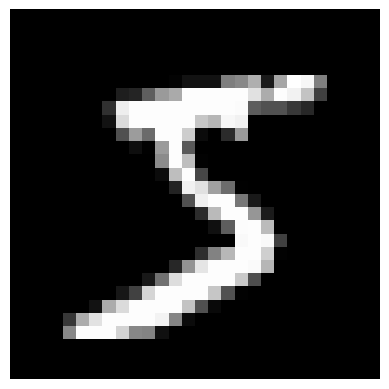

label: 5


In [28]:
import matplotlib.pyplot as plt
x, t = train_set[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

### 入力データの前処理

- 入力データを1列に並べる
    - (1, 28, 28) => (784, )
- データ型を`np.float32` に並べる
- 255で割る => 値が0から1の間に変換される

**Note**

MNISTクラスはこの処理をデフォルトとして設定済みである。以下はそのpythonコードの抜粋

```python
class MNIST(Dataset):
    def __init__(self, train=True,
                 transform=Compose([Flatten(),             # [前処理] 28*28をフラットなベクトルに変換
                                    ToFloat(),             # [前処理] Floatに変換
                                    Normalize(0., 255.)]), # [前処理] 標準化の実施
                 target_transform=None):                   # ラベルに対する前処理はなし
```



In [29]:
def f(x):
    '''
    俺々前処理関数。この関数オブジェクトをMNISTクラスの関数オブジェクトとして渡す
    '''
    x = x.flatten()           # データの1次元化
    x = x.astype(np.float32)  # 型変換(float64より負荷を軽減する)
    x /= 255.0                # ノーマライズ。値を0から1へ
    return x

train_set = dezero.datasets.MNIST(train=True, transform=f) # 関数オブジェクトを渡す
test_set = dezero.datasets.MNIST(train=False, transform=f) # 関数オブジェクトを渡す

## 51.2 MNISTの学習

### 前のステップからの変更点と重要ポイント

- ポイント
    - Spiralのときとほとんどコードを変更せずに学習できている。
    - Dataset, DatasetLoaderクラスを使うことでこれが実現できていることに注目する
- 前のステップからのコードの変更点
    - MNISTデータセットを使うようにした
    - ハイパーパラメータの値を変国した

![nn1](./STEP51.2.drawio.svg)

### 学習用のコード


このあとに活性化関数を変更し精度を上げていく。そのため現在精度は86%くらいになることをメモしておこう。

In [30]:
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)
#model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
#optimizer = optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.9101, accuracy: 0.5536
test loss: 1.5355, accuracy: 0.7490
epoch: 2
train loss: 1.2813, accuracy: 0.7702
test loss: 1.0454, accuracy: 0.8147
epoch: 3
train loss: 0.9245, accuracy: 0.8183
test loss: 0.7927, accuracy: 0.8374
epoch: 4
train loss: 0.7406, accuracy: 0.8400
test loss: 0.6585, accuracy: 0.8594
epoch: 5
train loss: 0.6365, accuracy: 0.8535
test loss: 0.5793, accuracy: 0.8641


## 51.3 モデルの改良

先程利用したニューラルネットワークの活性化関数は、シグモイド関数であった。これを`ReLu`に変更し精度を上げていく(勾配消失問題への対応)

### 活性化関す `ReLU` のグラフ形状

以下のコードは実践機械学習からの抜粋であり、Leaky Reluのプログラムだが、`alpha = 0` とすることで`ReLU`になる

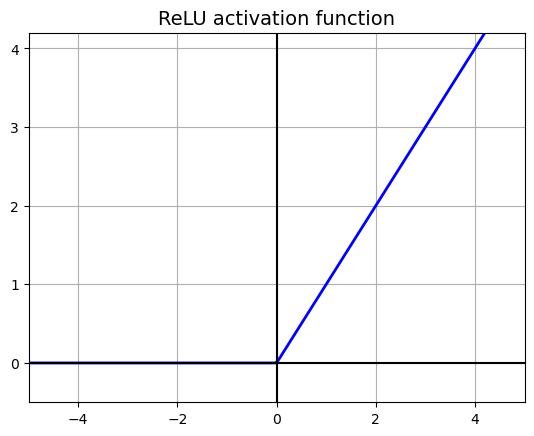

In [31]:
# alpha = 0 でReLu
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.00), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.title("ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

### DeZeroへの実装

```python
class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0)
        return y

    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0
        gx = gy * mask
        return gx


def relu(x):
    return ReLU()(x)
```

### 活性化関数, ReLUの適用とOptimizerをadamへ変更

### 51.2との変更点

変更点

- 活性化関数とシグモイドからReLUに変更
- OptimizerをSGDからADAMに変更
- 隠れそうを1層追加

5エポックで97%程度の精度がでていることがわかる

![nn2-2](./STEP51.3.drawio.svg)

In [32]:
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

#model = MLP((hidden_size, 10))
#optimizer = optimizers.SGD().setup(model)
# 隠れ層が1層増えていることに注意
model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
optimizer = optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 0.1915, accuracy: 0.9418
test loss: 0.0898, accuracy: 0.9717
epoch: 2
train loss: 0.0729, accuracy: 0.9771
test loss: 0.0759, accuracy: 0.9778
epoch: 3
train loss: 0.0486, accuracy: 0.9844
test loss: 0.0843, accuracy: 0.9748
epoch: 4
train loss: 0.0365, accuracy: 0.9877
test loss: 0.0739, accuracy: 0.9791
epoch: 5
train loss: 0.0254, accuracy: 0.9917
test loss: 0.0782, accuracy: 0.9814
